**Dataset Sampling and YOLO Label Creation from TrashNet**

In [5]:
!pip install datasets opencv-python-headless pyyaml ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


In [6]:
import random
from datasets import load_dataset
from PIL import Image
import os

# 1. Class mapping (TrashNet = 6 classes)
class_names = ["cardboard", "glass", "metal", "paper", "plastic", "trash"]
label2name = {i: n for i, n in enumerate(class_names)}

# 2. Load a small subset of the dataset
# Load the training split of the dataset, taking only the first 1000 examples
dataset = load_dataset("garythung/trashnet", split="train[:1000]")

# Group samples by class index
from collections import defaultdict

class_imgs = defaultdict(list)
for example in dataset:
    lbl = int(example['label'])
    if len(class_imgs[lbl]) < 10:  # up to 10 per class
        class_imgs[lbl].append(example)
    if all(len(class_imgs[i]) >= 10 for i in range(len(class_names))):
        break

# 3. Save images and create YOLO-format txts
os.makedirs("images", exist_ok=True)
os.makedirs("labels", exist_ok=True)
idx = 0
for lbl, samples in class_imgs.items():
    for ex in samples:
        fname = f"{label2name[lbl]}_{idx}.jpg"
        img = ex['image']
        img.save(f"images/{fname}", quality=85)
        w, h = img.size
        # YOLO bbox for full image: [class_idx, x_center, y_center, width, height] (normalized)
        label_line = f"{lbl} 0.5 0.5 1.0 1.0\n"
        with open(f"labels/{os.path.splitext(fname)[0]}.txt", "w") as f:
            f.write(label_line)
        idx += 1

print("Saved images and YOLOv8 labels:", len(os.listdir('images')), len(os.listdir('labels')))

Saved images and YOLOv8 labels: 30 30


**YOLOv8 Dataset Configuration YAML Generation**

In [7]:
import yaml
yaml_dict = {
    'train': os.path.abspath('images'),
    'val': os.path.abspath('images'),
    'names': class_names,
}
with open("trashnet_yolo.yaml", "w") as f:
    yaml.dump(yaml_dict, f)
print(yaml_dict)


{'train': '/content/images', 'val': '/content/images', 'names': ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']}


**YOLOv8 Nano Model Training with Augmentation**

In [8]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')
model.train(
    data='trashnet_yolo.yaml',
    epochs=15,
    imgsz=320,
    batch=4,
    augment=True
)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Ultralytics 8.3.176 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=trashnet_yolo.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=F

Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

 22        [15, 18, 21]  1    752482  ultralytics.nn.modules.head.Detect           [6, [64, 128, 256]]           
Model summary: 129 layers, 3,012,018 parameters, 3,012,002 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1032.2±160.2 MB/s, size: 1102.7 KB)


train: Scanning /content/labels... 30 images, 0 backgrounds, 0 corrupt: 100%|██████████| 30/30 [00:00<00:00, 1831.04it/s]

train: New cache created: /content/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1523.8±949.2 MB/s, size: 1245.4 KB)


val: Scanning /content/labels.cache... 30 images, 0 backgrounds, 0 corrupt: 100%|██████████| 30/30 [00:00<?, ?it/s]

Plotting labels to runs/detect/train/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15         0G      0.897      3.315      1.351          8        320: 100%|██████████| 8/8 [00:13<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]

                   all         30         30     0.0133          1       0.24      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15         0G     0.7087      3.281      1.188          7        320: 100%|██████████| 8/8 [00:06<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.32s/it]

                   all         30         30     0.0165          1      0.482      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15         0G     0.5332      3.161      1.108          5        320: 100%|██████████| 8/8 [00:09<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]

                   all         30         30     0.0177          1       0.63      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15         0G     0.4021      3.018      1.048          8        320: 100%|██████████| 8/8 [00:06<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.27s/it]

                   all         30         30     0.0189          1      0.664      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15         0G     0.3551      2.952     0.9981          6        320: 100%|██████████| 8/8 [00:06<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.15s/it]

                   all         30         30      0.021          1      0.633      0.609


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15         0G     0.3855      2.808      1.021          2        320: 100%|██████████| 8/8 [00:06<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

                   all         30         30     0.0235          1      0.656      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15         0G      0.285      2.636       0.96          2        320: 100%|██████████| 8/8 [00:06<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.21s/it]

                   all         30         30     0.0228          1      0.674      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/15         0G     0.2159       2.49     0.9584          2        320: 100%|██████████| 8/8 [00:07<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.14s/it]

                   all         30         30     0.0209          1      0.675      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/15         0G     0.2533      2.458     0.9129          2        320: 100%|██████████| 8/8 [00:07<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.31s/it]

                   all         30         30      0.733      0.533      0.702      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/15         0G     0.2835      2.084      0.987          2        320: 100%|██████████| 8/8 [00:06<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]

                   all         30         30      0.733      0.533      0.702      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/15         0G     0.2302      2.153     0.9744          2        320: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]

                   all         30         30      0.392      0.878      0.716      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/15         0G     0.2155      1.897     0.9275          2        320: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]

                   all         30         30      0.392      0.878      0.716      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/15         0G     0.2555      1.968     0.8963          2        320: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]

                   all         30         30      0.564      0.767      0.721       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/15         0G     0.2415      1.849     0.9132          2        320: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]

                   all         30         30      0.564      0.767      0.721       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/15         0G     0.2983      1.948     0.9176          2        320: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]

                   all         30         30      0.606      0.833      0.744      0.744



15 epochs completed in 0.053 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.176 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.95s/it]


                   all         30         30      0.687      0.865      0.749      0.746
             cardboard         10         10      0.938          1      0.995      0.995
                 glass         10         10      0.614      0.796      0.644      0.644
                 metal         10         10      0.509        0.8      0.609      0.599
Speed: 0.6ms preprocess, 160.5ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f1e6ddfdc90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

**Real-Time Inference and Pick-Point Visualization with OpenCV**


0: 320x320 1 glass, 1 metal, 85.0ms
Speed: 1.3ms preprocess, 85.0ms inference, 4.7ms postprocess per image at shape (1, 3, 320, 320)
Processing glass_14.jpg
Detections: 2
  Class: metal, Conf: 0.95
  Class: glass, Conf: 0.49


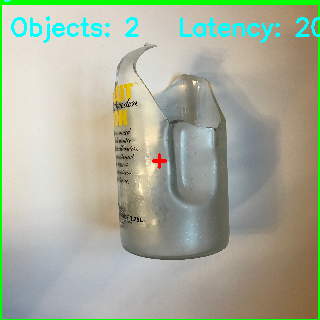


0: 320x320 1 cardboard, 71.7ms
Speed: 2.6ms preprocess, 71.7ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 320)
Processing cardboard_3.jpg
Detections: 1
  Class: cardboard, Conf: 0.79


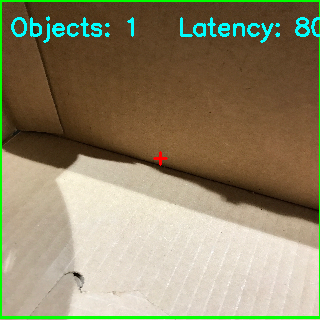


0: 320x320 1 metal, 69.8ms
Speed: 1.6ms preprocess, 69.8ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
Processing metal_25.jpg
Detections: 1
  Class: metal, Conf: 0.91


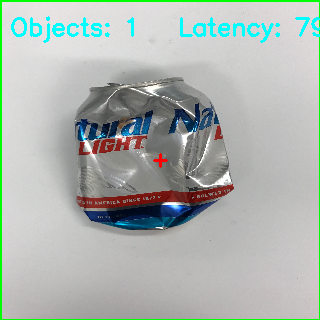


0: 320x320 1 metal, 72.9ms
Speed: 1.6ms preprocess, 72.9ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
Processing glass_18.jpg
Detections: 1
  Class: metal, Conf: 0.46


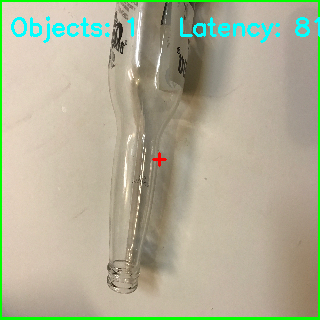


0: 320x320 1 cardboard, 73.8ms
Speed: 1.6ms preprocess, 73.8ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
Processing cardboard_7.jpg
Detections: 1
  Class: cardboard, Conf: 0.86


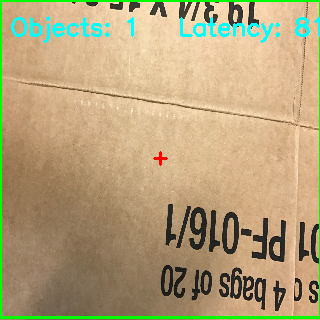


0: 320x320 1 metal, 96.1ms
Speed: 1.6ms preprocess, 96.1ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 320)
Processing glass_15.jpg
Detections: 1
  Class: metal, Conf: 0.35


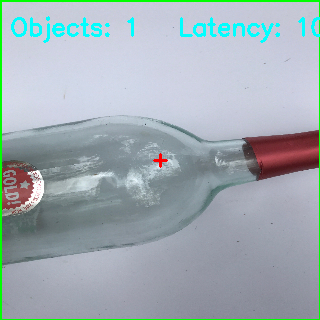


0: 320x320 1 metal, 77.2ms
Speed: 2.9ms preprocess, 77.2ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 320)
Processing metal_28.jpg
Detections: 1
  Class: metal, Conf: 0.91


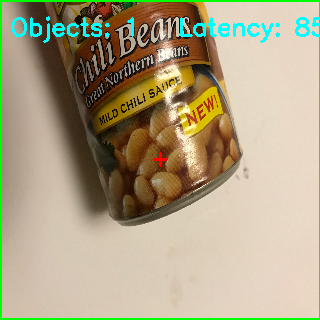


0: 320x320 1 cardboard, 1 metal, 79.8ms
Speed: 1.5ms preprocess, 79.8ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
Processing cardboard_6.jpg
Detections: 2
  Class: cardboard, Conf: 0.29
  Class: metal, Conf: 0.24


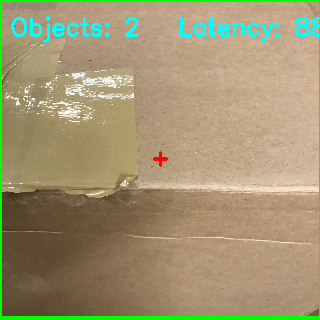


0: 320x320 1 cardboard, 1 metal, 89.8ms
Speed: 1.3ms preprocess, 89.8ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 320)
Processing cardboard_4.jpg
Detections: 2
  Class: cardboard, Conf: 0.89
  Class: metal, Conf: 0.17


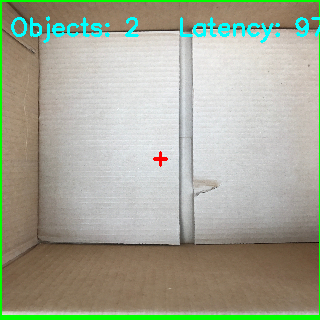


0: 320x320 1 cardboard, 122.5ms
Speed: 1.6ms preprocess, 122.5ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)
Processing cardboard_0.jpg
Detections: 1
  Class: cardboard, Conf: 0.92


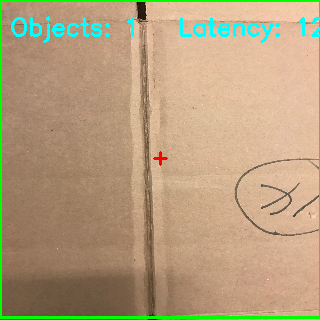

In [10]:
import cv2
import time
from ultralytics import YOLO
from google.colab.patches import cv2_imshow
import random
import os

model = YOLO('/content/runs/detect/train/weights/best.pt')

demo_imgs = random.sample(os.listdir('images'), 10)  # 10 random images

for fname in demo_imgs:
    frame = cv2.imread(f'images/{fname}')
    if frame is None:
        print(f"Image {fname} could not be loaded, skipping.")
        continue

    frame = cv2.resize(frame, (320, 320))  # consistent with training

    t0 = time.perf_counter()
    # Lower conf & iou for more detections

    results = model(frame, conf=0.15, iou=0.3)[0]

    latency = (time.perf_counter() - t0) * 1000

    print(f"Processing {fname}")
    print(f"Detections: {len(results.boxes)}")
    for box in results.boxes:
        cls = int(box.cls[0])
        conf = float(box.conf[0])
        print(f"  Class: {model.names[cls]}, Conf: {conf:.2f}")

    obj_count = 0
    for box in results.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        cx, cy = int((x1+x2)//2), int((y1+y2)//2)
        cls = int(box.cls[0])
        conf = float(box.conf[0])

        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.drawMarker(frame, (cx, cy), (0, 0, 255), cv2.MARKER_CROSS, 12, 2)
        label = f'{model.names[cls]}: {conf:.2f}'
        cv2.putText(frame, label, (x1, y1-8), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (250, 255, 50), 2)
        obj_count += 1

    cv2.putText(frame, f'Objects: {obj_count}   Latency: {latency:.1f} ms', (10, 35),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 0), 2)

    cv2_imshow(frame)
    cv2.waitKey(500)  # 0.5 sec pause

cv2.destroyAllWindows()
